# Creating the Gene Table

First, download the FASTA and GFF files for your organism and its plasmids from NCBI. We will use the *E. coli* K-12 MG1655 strain as an example, which does not have plasmids.

## Get information from GFF files

In [1]:
from pymodulon.gene_util import *
import pandas as pd

Enter the location of all your GFF files here:

In [2]:
gff_files = '../data/sequence_files/genome.gff3'

The following cell will convert all the GFF files into a single Pandas DataFrame for easy manipulation. Pseudogenes have multiple rows in a GFF file (one for each fragment), but only the first fragment will be kept.

In [3]:
keep_cols = ['accession','start','end','strand','gene_name','old_locus_tag','gene_product','ncbi_protein']

DF_annot = gff2pandas(gff_files,index='locus_tag')
DF_annot = DF_annot[keep_cols]

DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,
PP_0001,AE015451.2,147,1019,-,parB,None,probable chromosome-partitioning protein,AAN65635.1
PP_0002,AE015451.2,1029,1820,-,parA,None,probable chromosome partition protein,AAN65636.1
PP_0003,AE015451.2,1839,2489,-,rsmG,None,16S RNA methyltransferase,AAN65637.1
PP_0004,AE015451.2,2486,4381,-,trmF,None,tRNA uridine 5-carboxymethylaminomethyl modifi...,AAN65638.1
PP_0005,AE015451.2,5012,6382,-,trmE,None,GTPase,AAN65639.1


To ensure that the gene index used is identical to the expression matrix, load in your data.

In [4]:
DF_log_tpm = pd.read_csv('../data/interim/log_tpm_qc.csv',index_col=0)
DF_log_tpm.head()

,CJ522_f_1,CJ522_f_2,CJ522_f_3,CJ522_fg_1,CJ522_fg_2,CJ522_fg_3,CJ522_gfg_1,CJ522_gfg_2,CJ522_gfg_3,CJ522_gg_1,...,SRX7747533,SRX7747534,SRX7747535,SRX7747536,SRX801088,SRX801089,SRX801090,SRX801091,SRX801092,SRX801093
Geneid,,,,,,,,,,,,,,,,,,,,,
PP_0001,7.685238,7.426457,7.430784,7.953881,7.980323,7.976536,7.932174,7.801293,7.711432,7.628685,...,7.628545,7.530595,7.589691,7.556603,7.321314,7.512600,7.468847,7.533092,7.351183,7.172413
PP_0002,6.269452,6.240088,6.084228,6.477417,6.339458,6.712686,6.727164,6.253543,6.648412,6.544883,...,8.009672,7.913318,7.976721,8.031747,7.600528,7.823309,7.728147,8.309658,7.838074,7.821228
PP_0003,6.901146,6.558103,6.595930,6.804594,6.957070,6.977378,6.932945,6.515233,6.706640,6.588193,...,7.469212,7.484589,7.471962,7.476807,7.452703,7.616082,8.028794,8.390663,8.166730,7.689181
PP_0004,6.870057,6.535493,6.797775,6.976880,7.151846,7.166448,7.441744,7.301750,7.172066,6.904431,...,8.034617,7.723615,7.761359,7.750259,7.677756,7.922420,8.010009,8.453525,8.448452,8.222882
PP_0005,4.952532,5.362360,4.944388,4.765938,4.874653,4.928894,4.945763,4.961868,5.215403,4.976892,...,7.470875,7.028000,7.153636,7.116908,5.189638,5.331699,4.935606,4.954815,5.443880,5.504908


Check that the genes are the same in the expression dataset as in the annotation dataframe. Mismatched genes are listed below.

In [5]:
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


## (Optional) KEGG and COGs

### Generate nucleotide fasta files for CDS

Enter the location of all your fasta files here:

In [18]:
fasta = '../data/sequence_files/genome.fasta'

The following code generates CDS files using your FASTA and GFF3 files

In [19]:
from Bio import SeqIO

cds_list = []

seq = SeqIO.read(fasta,'fasta')
# Get gene information for genes in this fasta file
df_genes = DF_annot[DF_annot.accession == seq.id]
    
for i,row in df_genes.iterrows():
    cds = seq[row.start-1:row.end]
    if row.strand == '-':
        cds = seq[row.start-1:row.end].reverse_complement()
    cds.id = row.name
    cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
    cds_list.append(cds)

In [20]:
cds_list[:5]

[SeqRecord(seq=Seq('ATGGCCGTCAAGAAACGGGGTCTCGGACGTGGGTTGGATGCACTGCTCAGTGGT...TGA'), id='PP_0001', name='<unknown name>', description='parB', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGCTAAGGTATTCGCAATCGCGAACCAGAAAGGTGGTGTGGGCAAGACAACC...TAA'), id='PP_0002', name='<unknown name>', description='parA', dbxrefs=[]),
 SeqRecord(seq=Seq('TTGAGTTCCCTGGTCACCCCTCAACACGCTGAAGAGTTGTCCACAGGTGCGCGC...TGA'), id='PP_0003', name='<unknown name>', description='rsmG', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGGTGGATTTCCCTTCCCGTTTTGACGTGATCGTCATCGGCGGCGGCCATGCC...TGA'), id='PP_0004', name='<unknown name>', description='trmF', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGAACACTGTGCGTGAAACCATCGCCGCCATCGCCACGGCCCAGGGCCGGGGC...TAA'), id='PP_0005', name='<unknown name>', description='trmE', dbxrefs=[])]

Uncomment the line below to write the CDS file

In [22]:
SeqIO.write(cds_list,'../data/sequence_files/CDS.fna','fasta')

5564

### Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file

### Get KEGG IDs

Once you have the EggNOG annotations, load the annotation file

In [23]:
eggnog_file = '../data/external/eggNOG.annotations'

In [24]:
eggnog_file

'../data/sequence_files/eggNOG.annotations'

In [25]:
DF_eggnog = pd.read_csv(eggnog_file,sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

DF_eggnog.head()

,seed eggNOG ortholog,seed ortholog evalue,seed ortholog score,Predicted taxonomic group,Predicted protein name,Gene Ontology terms,EC number,KEGG_orth,KEGG_pathway,KEGG_module,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG Reaction,tax_scope,eggNOG OGs,bestOG_deprecated,COG,eggNOG free text description
locus_tag,,,,,,,,,,,,,,,,,,,,,
PP_0001,160488.PP_0001,1.800000e-156,558.5,Pseudomonas putida group,parB,NaN,NaN,ko:K03497,NaN,NaN,...,NaN,"ko00000,ko03000,ko03036,ko04812",NaN,NaN,NaN,Pseudomonas putida group,"1MW2E@1224,1RN65@1236,1YV94@136845,COG1475@1,C...",NA|NA|NA,L,Belongs to the ParB family
PP_0002,160488.PP_0002,1.900000e-144,518.5,Pseudomonas putida group,NaN,NaN,NaN,ko:K03496,NaN,NaN,...,NaN,"ko00000,ko03036,ko04812",NaN,NaN,NaN,Pseudomonas putida group,"1MV43@1224,1RNJK@1236,1YWDS@136845,COG1192@1,C...",NA|NA|NA,D,"PFAM Cobyrinic acid a,c-diamide synthase"
PP_0003,160488.PP_0003,6.900000e-121,439.9,Pseudomonas putida group,rsmG,NaN,2.1.1.170,ko:K03501,NaN,NaN,...,NaN,"ko00000,ko01000,ko03009,ko03036",NaN,NaN,NaN,Pseudomonas putida group,"1MY0K@1224,1RMRZ@1236,1YY70@136845,COG0357@1,C...",NA|NA|NA,J,Specifically methylates the N7 position of gua...
PP_0004,160488.PP_0004,0.000000e+00,1265.8,Pseudomonas putida group,gidA,NaN,NaN,ko:K03495,NaN,NaN,...,"RC00053,RC00209,RC00870","ko00000,ko03016,ko03036",NaN,NaN,NaN,Pseudomonas putida group,"1MU6F@1224,1RMM1@1236,1YVAI@136845,COG0445@1,C...",NA|NA|NA,D,NAD-binding protein involved in the addition o...
PP_0005,160488.PP_0005,1.600000e-255,888.3,Pseudomonas putida group,mnmE,NaN,NaN,ko:K03650,NaN,NaN,...,"RC00053,RC00209,RC00870","ko00000,ko01000,ko03016",NaN,NaN,NaN,Pseudomonas putida group,"1MUCQ@1224,1RN5S@1236,1YX79@136845,COG0486@1,C...",NA|NA|NA,J,Exhibits a very high intrinsic GTPase hydrolys...


Now we will pull the KEGG information from the eggNOG file, including orthology, pathway, module, and reactions for each gene.

In [26]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

,gene_id,database,kegg_id
2485,PP_0006,KEGG_pathway,map02024
2486,PP_0006,KEGG_pathway,map03060
2487,PP_0006,KEGG_pathway,map03070
2490,PP_0010,KEGG_pathway,map02020
2491,PP_0010,KEGG_pathway,map04112


### Save KEGG information

Uncomment the line below to save the KEGG file

In [27]:
DF_kegg.to_csv('../data/sequence_files/kegg_mapping.csv')

### Save COGs to annotation dataframe

In [28]:
DF_annot['COG'] = DF_eggnog.COG

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

## Uniprot ID mapping

The ``uniprot_id_mapping`` function is a python wrapper for the [Uniprot ID mapping tool](https://www.uniprot.org/uploadlists/). Use ``input_id=P_REFSEQ_AC`` if the FASTA/GFFf files are from RefSeq, and ``input_id=EMBL`` if the files are from Genbank.

In [29]:
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='P_REFSEQ_AC',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')
mapping_uniprot.head()

,ncbi_protein,uniprot


In [30]:
# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
PP_0001,AE015451.2,147,1019,-,parB,None,probable chromosome-partitioning protein,AAN65635.1,L,NaN
PP_0002,AE015451.2,1029,1820,-,parA,None,probable chromosome partition protein,AAN65636.1,D,NaN
PP_0003,AE015451.2,1839,2489,-,rsmG,None,16S RNA methyltransferase,AAN65637.1,J,NaN
PP_0004,AE015451.2,2486,4381,-,trmF,None,tRNA uridine 5-carboxymethylaminomethyl modifi...,AAN65638.1,D,NaN
PP_0005,AE015451.2,5012,6382,-,trmE,None,GTPase,AAN65639.1,J,NaN


## Add Biocyc Operon information

To obtain operon information from Biocyc, follow the steps below

1. Go to [Biocyc.org](https://biocyc.org/) (you may need to create an account and/or login)
2. Change the organism database to your organism/strain
3. Select **SmartTables** -> **Special SmartTables**
4. Select **"All genes of \<organism\>"**
5. Select the **"Gene Name"** column
6. Under **"ADD TRANSFORM COLUMN"** select **"Genes in same transcription unit"**
7. Select the **"Genes in same transcription unit"** column
8. Under **"ADD PROPERTY COLUMN"** select **"Accession-1"**
9. Under **OPERATIONS**, select **"Export"** -> **"to Spreadsheet File..."**
10. Select **"common names"** and click **"Export smarttable"**
11. Add file location below and run the code cell

In [31]:
biocyc_file =  '../data/external/Biocyc_KT2440.txt'

DF_biocyc = pd.read_csv(biocyc_file,sep='\t')

# Remove genes with no accession
DF_biocyc = DF_biocyc[DF_biocyc['Accession-1'].notnull()]

# Set the accession (i.e. locus tag) as index
DF_biocyc = DF_biocyc.set_index('Accession-1').sort_values('Left-End-Position')

# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(DF_annot.index)

# Reformat transcription units
DF_biocyc['operon_list'] = DF_biocyc['Accession-1.1'].apply(reformat_biocyc_tu)

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list
locus_tag,,,,,,,
PP_0001,parB,147.0,1019.0,chromosome-partitioning protein,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004
PP_0002,parA,1029.0,1820.0,chromosome partition protein,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004
PP_0003,rsmG,1839.0,2489.0,16S RNA methyltransferase,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004
PP_0004,mnmG,2486.0,4381.0,5-carboxymethylaminomethyluridine-tRNA synthas...,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004
PP_0005,mnmE,5012.0,6382.0,5-carboxymethylaminomethyluridine-tRNA synthas...,mnmE,PP_0005,PP_0005


### Assign unique IDs to operons

The following code assigns unique names to each operon

In [32]:
# Get all operons
operons = DF_biocyc['operon_list'].unique()

# Map each operon to a unique string
operon_dict = {operon: "Op"+str(i) for i, operon in enumerate(operons)}

# Add names to dataframe
DF_biocyc['operon'] = [operon_dict[op] for op in DF_biocyc["operon_list"]]

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list,operon
locus_tag,,,,,,,,
PP_0001,parB,147.0,1019.0,chromosome-partitioning protein,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004,Op0
PP_0002,parA,1029.0,1820.0,chromosome partition protein,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004,Op0
PP_0003,rsmG,1839.0,2489.0,16S RNA methyltransferase,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004,Op0
PP_0004,mnmG,2486.0,4381.0,5-carboxymethylaminomethyluridine-tRNA synthas...,mnmG // rsmG // parA // parB,PP_0004 // PP_0003 // PP_0002 // PP_0001,PP_0001;PP_0002;PP_0003;PP_0004,Op0
PP_0005,mnmE,5012.0,6382.0,5-carboxymethylaminomethyluridine-tRNA synthas...,mnmE,PP_0005,PP_0005,Op1


Finally, merge the Biocyc information with the main annotation DataFrame

In [33]:
DF_annot['operon'] = DF_biocyc['operon']

## Clean up and save annotation

First, we will re-order the annotation columns

In [34]:
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','accession','old_locus_tag','start','end','strand','gene_product','COG','uniprot','operon']
else:
    order = ['gene_name','accession','start','end','strand','gene_product','COG','uniprot','operon']
    
DF_annot = DF_annot[order]

In [35]:
DF_annot.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
PP_0001,parB,AE015451.2,None,147,1019,-,probable chromosome-partitioning protein,L,NaN,Op0
PP_0002,parA,AE015451.2,None,1029,1820,-,probable chromosome partition protein,D,NaN,Op0
PP_0003,rsmG,AE015451.2,None,1839,2489,-,16S RNA methyltransferase,J,NaN,Op0
PP_0004,trmF,AE015451.2,None,2486,4381,-,tRNA uridine 5-carboxymethylaminomethyl modifi...,D,NaN,Op0
PP_0005,trmE,AE015451.2,None,5012,6382,-,GTPase,J,NaN,Op1


## Final statistics

The following graphs show how much information is available for the organism.

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

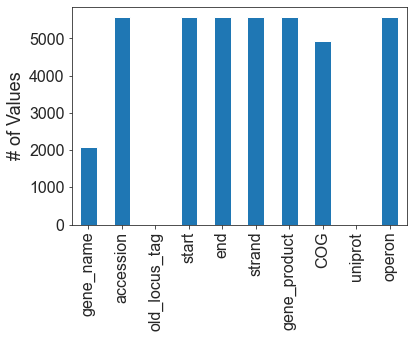

In [37]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

Some organisms are missing gene names, so these will be filled with locus tag gene names.

In [38]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

 COG letters will also be converted to the full name.

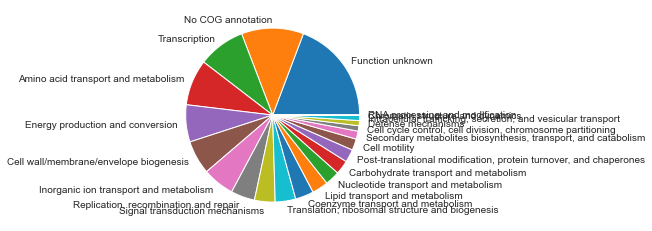

In [39]:
# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

Uncomment the following line to save the gene annotation dataset

In [40]:
DF_annot.to_csv('../data/processed_data/gene_info.csv')

#Skipped

## GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2

1. Go to [AmiGO 2](http://amigo.geneontology.org/amigo/search/annotation)
1. Filter for your organism
1. Click ``CustomDL``
1. Drag ``GO class (direct)`` to the end of your Selected Fields
1. Enter the location of your GO annotation file below and run the following code block

In [41]:
go_file = '../data/external/AmiGO2_KT2440.txt'

In [42]:
DF_GO = pd.read_csv(go_file,sep='\t',header=None,usecols=[2,10,17])
DF_GO.columns = ['gene_name','gene_id','gene_ontology']

In [43]:
DF_GO

,gene_name,gene_id,gene_ontology
0,rpoN,ntrA|PP_0952,identical protein binding
1,rpoN,ntrA|PP_0952,DNA-binding transcription activator activity
2,rpoN,ntrA|PP_0952,protein-DNA complex
3,rpoN,ntrA|PP_0952,transcription regulatory region sequence-speci...
4,rpoN,ntrA|PP_0952,"positive regulation of transcription, DNA-temp..."
...,...,...,...
161,nicA,ndhS|PP_3947,obsolete oxidation-reduction process
162,PP_2144,NaN,DNA-binding transcription repressor activity
163,PP_2144,NaN,DNA-binding transcription activator activity
164,PP_2144,NaN,protein-DNA complex


In [44]:
DF_GO.gene_id.fillna(DF_GO.gene_name,inplace=True)
DF_GO = DF_GO[['gene_id','gene_ontology']]

Take a look at the ``gene_id`` column:
1. Make sure there are no null entries
2. Check which naming convention is used (locus tag, new locus tag, or gene name)

If it looks like it uses the old locus tag, set old_locus_tag to ``True``.

In this example, the ``gene_id`` column needs to be altered slightly to match with the gene name. This may not be necessary for your organism.

In [45]:
def format_go_gene_id(gene_id):
    locus_tags = [item for item in gene_id.split('|') if re.match('b\d{4}',item)]
    if len(locus_tags) > 0:
        return locus_tags[0]
    else:
        return None

DF_GO.gene_id = DF_GO.gene_id.apply(format_go_gene_id)

D:\Users\hyung\Anaconda3\envs\pymodulon\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [46]:
DF_GO

,gene_id,gene_ontology
0,None,identical protein binding
1,None,DNA-binding transcription activator activity
2,None,protein-DNA complex
3,None,transcription regulatory region sequence-speci...
4,None,"positive regulation of transcription, DNA-temp..."
...,...,...
161,None,obsolete oxidation-reduction process
162,None,DNA-binding transcription repressor activity
163,None,DNA-binding transcription activator activity
164,None,protein-DNA complex


Now we remove null entries

In [98]:
DF_GO = DF_GO[DF_GO.gene_id.notnull()]

In [99]:
naming = 'locus_tag' # Can be "gene_name" or "old_locus_tag"

if naming != 'locus_tag':
    convert_tags = {value:key for key,value in DF_annot[naming].items()}
    DF_GO.gene_id = DF_GO.gene_id.apply(lambda x: convert_tags[x])

In [100]:
DF_GO.head()

,gene_id,gene_ontology


Uncomment the line below to save the annotations

In [47]:
DF_GO[['gene_id','gene_ontology']].to_csv('../data/sequence_files/GO_annotations.csv')